In [1]:
from tensorflow.keras.applications import VGG16
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers



import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

2.3.0
/device:GPU:0
Num GPUs Available:  1


In [6]:
from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.keras.constraints import Constraint
from tensorflow.python.util.tf_export import keras_export

@keras_export('keras.constraints.UnitSumNonNeg', 'keras.constraints.unit_sum_non_neg')
class UnitSumNonNeg(Constraint):
  """Limits weights to be non-negative and with sum equal to one

  Also available via the shortcut function `keras.constraints.unit_sum_non_neg`.
  """

  def __call__(self, w):
    
    aux = w * math_ops.cast(math_ops.greater_equal(w, 0.), K.floatx())
    
    return aux/ (
        K.epsilon() + math_ops.reduce_sum(aux, keepdims=True))



class OWAPooling(tf.keras.layers.Layer):
    def __init__(self,
               pool_size=(2, 2),
               strides=None,
               padding='valid',
               data_format=None,
               name=None,
               sort=True,
               constraint=True, 
               train=True, 
               **kwargs):
        super(OWAPooling, self).__init__(name=name, **kwargs)
        if data_format is None:
            data_format = backend.image_data_format()
        if strides is None:
            strides = pool_size

        self.pool_size = conv_utils.normalize_tuple(pool_size, 2, 'pool_size')
        self.strides = self.pool_size
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.input_spec = InputSpec(ndim=4)
        self.sort = sort
        self.constraint = constraint
        self.train = train
    def build(self, input_shape):
      
       self.kernel = np.resize(np.random.dirichlet(np.ones(4),size=1), self.pool_size)
       if self.constraint: 
           self.kernel_TENSOR = tf.Variable(initial_value = self.kernel, trainable=self.train, dtype='float32', constraint=UnitSumNonNeg())
       else:
           self.kernel_TENSOR = tf.Variable(initial_value = self.kernel, trainable=self.train, dtype='float32')

    def sort_p(self, inputs):

        _, pool_height, pool_width, channels, elems = inputs.get_shape().as_list()
        inputs = tf.reshape(inputs, [-1, elems]) # Reshape tensor
        inputs = tf.sort(inputs, axis=-1, direction='DESCENDING', name=None)
        # Reshape
        inputs = tf.reshape(inputs, [-1, pool_height, pool_width, channels, elems]) # Reshape tensor
        return inputs

    def call(self, inputs):

        _, height, width, channels = inputs.get_shape().as_list()
        pad_bottom = self.pool_size[0] * height%self.pool_size[0]
        pad_right = self.pool_size[1] * width%self.pool_size[1]

        if(self.padding=='SAME'): # Complete size to pad 'SAME'
            paddings = tf.constant([[0, 0], [0, pad_bottom], [0, pad_right], [0, 0]])
            inputs = tf.pad(inputs, paddings, "CONSTANT")

        # Extract pooling regions
        stride = [1, self.strides[0], self.strides[1], 1]
        ksize = [1, self.pool_size[0], self.pool_size[1], 1]

        inputs = tf.image.extract_patches(inputs, sizes = ksize, strides = stride,
                            rates = [1, 1, 1, 1], padding='SAME')

        _, pool_height, pool_width, elems = inputs.get_shape().as_list()

        # Extract pooling regions for each channel
        elems =  int(elems / channels)
        inputs = tf.reshape(inputs, [-1, pool_height, pool_width, elems, channels]) # Reshape tensor
        inputs = tf.transpose(inputs,perm = [0, 1, 2, 4, 3])

        # Sort values for pooling
        if self.sort:
            inputs = self.sort_p(inputs)

        weights = tf.squeeze(tf.reshape(self.kernel_TENSOR, [self.pool_size[0] * self.pool_size[1],1]))
        weights = tf.expand_dims(weights, axis=0)
        weights = tf.expand_dims(weights, axis=0)
        weights = tf.expand_dims(weights, axis=0)
        weights = tf.expand_dims(weights, axis=0)
        if inputs.shape[0] is not None:
            weights = tf.repeat(weights, axis=0, repeats = inputs.shape[0])
        weights = tf.repeat(weights, axis=1, repeats = inputs.shape[1])
        weights = tf.repeat(weights, axis=2, repeats = inputs.shape[2])
        weights = tf.repeat(weights, axis=3, repeats = inputs.shape[3])
        inputs = tf.math.multiply(weights, inputs)
        inputs = tf.reduce_sum(inputs,4)  #Reduce de 4th dimension
        return inputs

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        if self.data_format == 'channels_first':
            rows = input_shape[2]
            cols = input_shape[3]
        else:
            rows = input_shape[1]
            cols = input_shape[2]
        rows = conv_utils.conv_output_length(rows, self.pool_size[0], self.padding,
                                         self.strides[0])
        cols = conv_utils.conv_output_length(cols, self.pool_size[1], self.padding,
                                         self.strides[1])
        if self.data_format == 'channels_first':
            return tensor_shape.TensorShape(
                [input_shape[0], input_shape[1], rows, cols])
        else:
            return tensor_shape.TensorShape(
                [input_shape[0], rows, cols, input_shape[3]])
            
    def get_config(self):
        config = {
            'kernel':
                self.kernel_TENSOR,
            'kernel_size':
                self.kernel_TENSOR.shape,
            'strides':
                self.strides,
            'padding':
                self.padding,
            'data_format':
                self.data_format
        }
        base_config = super(OWAPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



170500096/170498071 [==============================] - 4s 0us/step


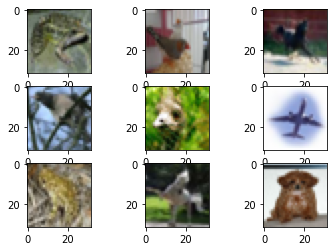

In [3]:
# load train and test dataset
def load_dataset():
  # load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

trainX, trainY, testX, testY = load_dataset()
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i+645])
# show the figure
plt.show()

In [4]:
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0

	return train_norm, test_norm

In [7]:
# define cnn model
def define_model():
    model = Sequential()
    conv_base = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels 
    )
    i = 0
    for layer in conv_base.layers:
        if("pool" in layer.name):
            model.add(OWAPooling(name='OWAPoolingNR'+str(i+1), sort=True, constraint=True, train=False))
            i = i + 1
            #model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
            
        else:    
            model.add(layer)

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='hidden1'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu', name='hidden2'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', name='predictions'))

    # initiate SGD optimizer
    sgd = optimizers.SGD(lr=0.001, momentum=0.9)

    # For a multi-class classification problem
    model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])

    model.summary()
    return model
#model = define_model()

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(14, 4))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss_values, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = range(1, len(loss_values) + 1)

    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [9]:

# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# define model
model = define_model()

es = EarlyStopping(patience=5, monitor='val_accuracy', mode='max')
# mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# fit model
history = model.fit(trainX, trainY, epochs=5, batch_size=32, validation_data=(testX, testY), callbacks=[es])

#We load the best weights saved by the ModelCheckpoint
#model.load_weights('./weights.h5')

# evaluate model
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))
# learning curves
summarize_diagnostics(history)

# entry point, run the test harness
#run_test_harness()

#model.save('my_model_OWA_Training.h5')

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
OWAPoolingNR1 (OWAPooling)   (None, 16, 16, 64)        4         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
OWAPoolingNR2 (OWAPooling)   (None, 8, 8, 128)         4         
_________________________________________________________

OSError: ignored

In [ ]:
for layer in model.layers: # go through until last layer
  if("OWAPooling" in layer.name):
      print(tf.reduce_sum(layer.weights))

NameError: ignored